# Всем привет!

По ноутбуку можно найти много markdown-ов, так что смотрим внимательнее!

In [115]:
import pandas as pd
import warnings
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
warnings.filterwarnings("ignore")

In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from torch.utils.data import Dataset, TensorDataset
from sklearn import preprocessing
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms as T

from sklearn.preprocessing import LabelEncoder, QuantileTransformer, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler, OneHotEncoder, RobustScaler
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer


In [211]:
df = pd.read_csv('train.csv', sep=';',parse_dates=['f1'])
macro = pd.read_csv('macro.csv',parse_dates=['timestamp'])
df_test = pd.read_csv('test.csv', sep=';', parse_dates=['f1'])

In [212]:
df.drop_duplicates(inplace = True)

In [213]:
df.dropna(how='all', inplace=True)

# Выбор моделей, архитектуры сетки, препроцессинг и т. д.

#### `Киллер-фича` №1

На просторах интернета можно нарыть много всего интересного, например датасет [macro](https://github.com/catherinehata/Sberbank-Russian-Housing-Market/blob/master/macro.csv).
Как я понял наши данные вроде как с [этого](https://www.kaggle.com/competitions/sberbank-russian-housing-market/overview) соревнования, всячиски перемешанные + какие-то новые и т. д. Как раз там и можно было найти найти `macro` и другие интересные штуки


macro.csv: data on Russia's macroeconomy and financial sector (could be joined to the train and test sets on the "timestamp" column)

Почему бы этим не воспользоваться?

In [214]:
column_types = macro.dtypes
categorical_columns = column_types[column_types == 'object'].index.tolist()
categorical_columns

['child_on_acc_pre_school',
 'modern_education_share',
 'old_education_build_share']

In [215]:
macro = macro.drop(categorical_columns, axis=1)

In [216]:
columns_nan = macro.columns[macro.isna().any()].tolist()
imputer = SimpleImputer(strategy='mean')
macro[columns_nan] = imputer.fit_transform(macro[columns_nan])

In [217]:
macro = macro.rename(columns={'timestamp': 'f1'})

merged_data = pd.merge(df, macro, on='f1', how='left')
df = merged_data

merged_data_1 = pd.merge(df_test, macro, on='f1', how='left')
df_test = merged_data_1

In [218]:
y = df['target']  
df = df.drop(['target', 'id'], axis=1)

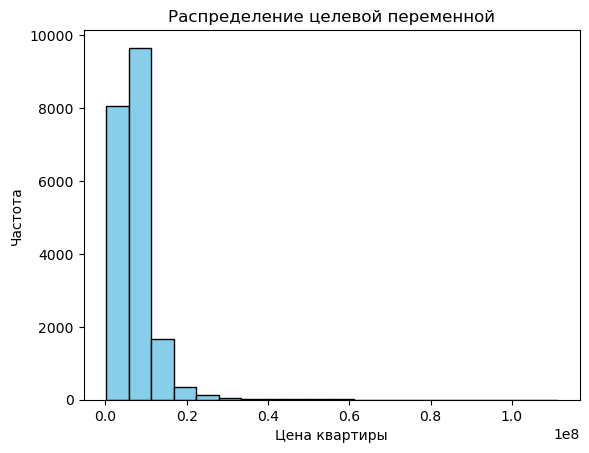

In [219]:
plt.hist(y, bins=20, color='skyblue', edgecolor='black')

plt.xlabel('Цена квартиры')
plt.ylabel('Частота')
plt.title('Распределение целевой переменной')

plt.show()

#### `Киллер-фича` №2

Предварительное логарифмирование целевой переменной может помочь сделать ее распределение более нормальным, что может улучшить производительность модели. Это может быть особенно полезно, если распределение целевой переменной смещено или имеет тяжелые хвосты

In [220]:
y = np.log1p(y)

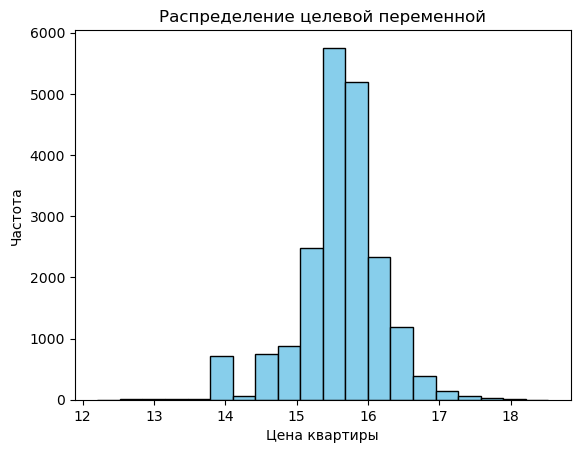

In [221]:
plt.hist(y, bins=20, color='skyblue', edgecolor='black')

plt.xlabel('Цена квартиры')
plt.ylabel('Частота')
plt.title('Распределение целевой переменной')

plt.show()

## Препроц

В препроцессинге с `train` и `macro` ничего интересного нет, заполнили пропущенные, перекодировали категориальные, поработали с отдельными колонками, перемаштабировали

In [222]:
mapping = {
    'satisfactory': 2,
    'poor': 1,
    'no data': 0,
    'excellent': 4,
    'good': 3
}
df['f153'] = df['f153'].replace(mapping)

In [223]:
columns_nan = df.columns[df.isna().any()].tolist()
imputer = SimpleImputer(strategy='mean')


df[columns_nan] = imputer.fit_transform(df[columns_nan])

In [224]:
df = df.drop(['f75'], axis=1)

Вся эта чудесная тема с `yearmonth`, `yearweek` и т.д. была позаимствована из каких-то тетрадок с соревнования сбера

In [225]:
df["yearmonth"] = df["f1"].dt.year*100 + df["f1"].dt.month

df["yearweek"] = df["f1"].dt.year*100 + df["f1"].dt.weekofyear

df["year"] = df["f1"].dt.year

df["month_of_year"] = df["f1"].dt.month

df["week_of_year"] = df["f1"].dt.weekofyear

df["day_of_week"] = df["f1"].dt.weekday


df['f1'] = [pd.to_datetime(date, format='%d.%m.%Y').timestamp() for date in df['f1']]

In [226]:
column_types = df.dtypes

categorical_columns = column_types[column_types == 'object'].index.tolist()

for col in categorical_columns:
    df[col] = LabelEncoder().fit_transform(df[col])

In [227]:
scaler = preprocessing.RobustScaler()
df = scaler.fit_transform(df.values)

In [228]:
X_train, X_val, y_train, y_val = train_test_split(df,
                                                  y, test_size=0.2, random_state=42)

## Autoencoder

Тут всё просто, строим `autoencoder` для сокращения размерности признаков

In [229]:
class Autoencoder(nn.Module):    
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()

        self.encoder1 = nn.Linear(input_size, 256)
        self.encoder2 = nn.Linear(256, 128)
        self.encoder3 = nn.Linear(128, 64)

        self.decoder1 = nn.Linear(64, 128)
        self.decoder2 = nn.Linear(128, 256)
        self.decoder3 = nn.Linear(256, input_size)

    def encoder(self, x):
        x = F.relu(self.encoder1(x))
        x = F.relu(self.encoder2(x))
        x = F.relu(self.encoder3(x))
        return x

    def decoder(self, x):
        x = F.relu(self.decoder1(x))
        x = F.relu(self.decoder2(x))
        x = F.relu(self.decoder3(x))
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [134]:
latent_dim = 8
autoencoder = Autoencoder(input_size=X_train.shape[1], hidden_size=latent_dim)
encoded_X_train = autoencoder.encoder(torch.tensor(X_train, dtype=torch.float32)).detach().numpy()
encoded_X_val = autoencoder.encoder(torch.tensor(X_val).float()).detach().numpy()

In [135]:
encoded_X_train

array([[0.        , 0.10929207, 0.        , ..., 0.        , 0.19568649,
        0.21861196],
       [0.1321752 , 0.        , 0.        , ..., 0.        , 0.04287545,
        0.04706204],
       [0.        , 0.        , 0.        , ..., 0.        , 7.0089965 ,
        6.978273  ],
       ...,
       [0.0392362 , 0.01023822, 0.        , ..., 0.        , 0.0545504 ,
        0.14161378],
       [0.10089326, 0.064913  , 0.        , ..., 0.        , 0.0881343 ,
        0.23017375],
       [0.10887635, 0.04555937, 0.        , ..., 0.03795375, 0.10314162,
        0.08714653]], dtype=float32)

In [136]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Можно много как по-разному играться с архитектурой сетки, но как выяснилось позже это не самое главное

In [137]:
class Classifier(nn.Module):
    def __init__(self, input_size):
        super(Classifier, self).__init__()
        self.norm = nn.BatchNorm1d(64)
        self.fc0 = nn.Linear(input_size, 128)
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.5) 

    def forward(self, x):
        x = self.norm(x)
        x = torch.relu(self.fc0(x))
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        return x
    
    def get_embed(self, x):
        x = torch.relu(self.fc0(x))
        x = torch.relu(self.fc1(x))
        return x


model = Classifier(input_size=encoded_X_train.shape[1]).to(device)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

Можно заметить интересную вещь `get_embed`. Это намёк на следующий этап моего решения!

In [138]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

bs = 8

train_dataset = CustomDataset(encoded_X_train, y_train.values)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

val_dataset = CustomDataset(encoded_X_val, y_val.values)
val_loader = DataLoader(val_dataset, batch_size=bs)

In [139]:
num_epochs = 20
train_losses = []


for epoch in range(num_epochs):
    embeddings_train = []
    y_train_for_emb = []
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        y_train_for_emb.extend(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        embeddings = model.get_embed(inputs)
        embeddings = [a.detach().cpu().numpy() for a in embeddings]

        embeddings_train.extend(embeddings)


    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

model.eval()
val_preds = []
val_labels = []
embeddings_test = []
y_test_for_emb = []

with torch.no_grad():
    for inputs, labels in val_loader:
        y_test_for_emb.extend(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        val_preds.extend(outputs.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

        embeddings = model.get_embed(inputs).cpu().numpy()
        embeddings_test.extend(embeddings)

Epoch 1/20, Loss: 7.6816
Epoch 2/20, Loss: 1.4687
Epoch 3/20, Loss: 1.0652
Epoch 4/20, Loss: 0.7204
Epoch 5/20, Loss: 0.5158
Epoch 6/20, Loss: 0.4223
Epoch 7/20, Loss: 0.3786
Epoch 8/20, Loss: 0.3619
Epoch 9/20, Loss: 0.3619
Epoch 10/20, Loss: 0.3620
Epoch 11/20, Loss: 0.3618
Epoch 12/20, Loss: 0.3620
Epoch 13/20, Loss: 0.3616
Epoch 14/20, Loss: 0.3620
Epoch 15/20, Loss: 0.3618
Epoch 16/20, Loss: 0.3620
Epoch 17/20, Loss: 0.3619
Epoch 18/20, Loss: 0.3615
Epoch 19/20, Loss: 0.3616
Epoch 20/20, Loss: 0.3614


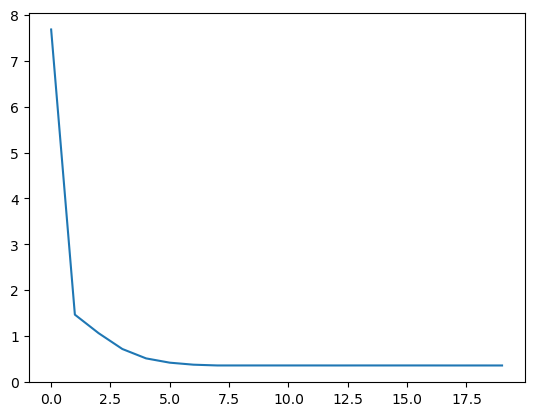

In [140]:
plt.plot(train_losses);

In [141]:
X_val_encoded = torch.tensor(encoded_X_val, dtype=torch.float32)

In [142]:
model.eval()
with torch.no_grad():
    predictions = model(X_val_encoded)

predictions_np = predictions.numpy()

In [231]:
from sklearn.metrics import mean_squared_log_error

true_labels = y_val.values
predictions = predictions_np.flatten()

После того как мы обучили модель на логарифмированных значениях целевой переменной, чтобы получить предсказания для тестового набора данных, нам нужно будет обратно преобразовать предсказанные логарифмы в их исходные значения

In [232]:
original_predictions = np.expm1(true_labels)
preds = np.expm1(predictions)

In [233]:
msle = mean_squared_log_error(original_predictions, preds)

print("MSLE:", msle)

MSLE: 0.36449225991282974


Можно было бы на этом закончить и довольными пойти предиктить `test`, но есть секретная информация, что нейронки не очень хорошо работают с табличными данными, поэтому надо попробовать на эмбеддингах научить чему-нибудь наш любимый `CatBoost`

## CatBoost

#### `Киллер-фича` №3

In [145]:
embeddings_train = np.array(embeddings_train)
embeddings_test = np.array(embeddings_test)
y_train_for_emb = np.array(y_train_for_emb)

In [146]:
l1 = np.concatenate((embeddings_train, X_train), axis=1)
l2 = np.concatenate((embeddings_test, X_val), axis=1)

Изначально я его учил только на эмбеддингах, но это не давало существенного прироста по метрике, поэтому было решено склеить всё это дело с полноценным `train` куском (предобработанным разумеется)

In [147]:
from catboost import CatBoostRegressor

In [148]:
cb = TransformedTargetRegressor(
                        regressor = CatBoostRegressor(iterations=1000,
                           learning_rate=0.01,
                           depth=11,
                           early_stopping_rounds=10,
                           random_seed=42,
                            verbose = 0)
                        ,
    transformer = QuantileTransformer(n_quantiles = 1000 , output_distribution = 'normal')
)

In [149]:
cb.fit(l1, y_train)

TransformedTargetRegressor(regressor=<catboost.core.CatBoostRegressor object at 0x2ac1cc9d0>,
                           transformer=QuantileTransformer(output_distribution='normal'))

Тут тоже обратно преобразовываем предсказанные логарифмы в их исходные значения

In [152]:
original_predictions = np.expm1(y_val)
preds = np.expm1(y_pred_best)

In [153]:
msle = mean_squared_log_error(original_predictions, preds)

print("MSLE:", msle)

MSLE: 0.21655429995270925


Можно увидеть насколько `CatBoost` лучше работает с табличными данными

# Предиктим

In [237]:
df = pd.read_csv('train.csv', sep=';',parse_dates=['f1'])
macro = pd.read_csv('macro.csv',parse_dates=['timestamp'])
df_test = pd.read_csv('test.csv', sep=';', parse_dates=['f1'])
df1 = pd.read_csv('train_2.csv',parse_dates=['timestamp'])
# df1 = pd.read_csv('train_without_noise.csv',parse_dates=['timestamp'])
nndf = pd.read_csv('train_3.csv', parse_dates=['timestamp'])

In [238]:
df.drop_duplicates(inplace = True)

In [239]:
df.dropna(how='all', inplace=True)

In [240]:
df1.drop_duplicates(inplace = True)

In [241]:
df1.dropna(how='all', inplace=True)

In [242]:
nndf.drop_duplicates(inplace = True)

In [243]:
nndf.dropna(how='all', inplace=True)

## Новый трэйн

#### `Киллер-фича` №4

В том же самом кагловском соревновании от сбера, где мы нашли датасет `macro`, можно изучить и сам `train` (train_2.csv), который там будет чуть по-больше
$ => $ От туда можно взять себе ещё данных для обучения.

Позже, когда место на лидерборде сильно пошатнулось, а что-то сделать хотелось, я понял, что мне нужно больше данных 

Соу, нашёл какого-то препода, который выложил где-то у себя на гите домашку по ML с похожим датасетом (train_3.csv), но с новыми данными!
К сожалению там была только ссылка на скачивание $ - $  [ссылка](https://docs.google.com/uc?export=download&id=1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX). Этот датаест вроде как не даёт существенного прироста по метрике, но решил его прикрутить в итоговое решение, круто же звучит $ - $ обучался на 3 датасетах

### Главный вопрос вот в чём

<table><tr>
<td> <img src="https://c.tenor.com/xZMms5TtDVwAAAAd/tenor.gif" alt="Drawing" style="width: 500px;"/> </td>
<td> <img 

Вопрос правда интересный (надеюсь гифку с Дикаприо будет видно)

В общем и целом, такое чувство, что можно бесконечно находить дополнительные данные для обучения на этот датасет

In [244]:
df = df.drop(['f75', 'id'], axis=1)
df1 = df1.drop(['id'], axis=1)
nndf = nndf.drop(['id'], axis=1)

Соу, что мы делаем

Ищем в большом датасете от сбера те колонки, которые есть только в нём и склеиваем их с нашим, родным датасетом

In [245]:
df1.columns = df.columns

In [246]:
merged = pd.merge(df1, df, indicator=True, how='outer')

# Выбор только тех строк, которые присутствуют только в df1
rows_only_in_df1 = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])

In [247]:
df = pd.concat([df, rows_only_in_df1])

In [248]:
nndf.columns = df.columns

In [249]:
merged = pd.merge(nndf, df, indicator=True, how='outer')

# Выбор только тех строк, которые присутствуют только в nndf
rows_only_in_nndf = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])

In [250]:
df = pd.concat([df, rows_only_in_nndf])

In [251]:
df.drop_duplicates(inplace = True)

In [252]:
df.shape

(57389, 291)

Дальше делаем всё тоже самое, что и раньше

## MACRO

In [253]:
column_types = macro.dtypes
categorical_columns = column_types[column_types == 'object'].index.tolist()
macro = macro.drop(categorical_columns, axis=1)

columns_nan = macro.columns[macro.isna().any()].tolist()
imputer = SimpleImputer(strategy='mean')
macro[columns_nan] = imputer.fit_transform(macro[columns_nan])

macro = macro.rename(columns={'timestamp': 'f1'})

merged_data = pd.merge(df, macro, on='f1', how='left')
df = merged_data
merged_data_1 = pd.merge(df_test, macro, on='f1', how='left')
df_test = merged_data_1

In [254]:
X = df.drop(['target'], axis=1)
y = df['target']

test = df_test.drop(['id', 'f75'], axis=1)

Решил это просто закоментить. Пробовал метод Бокса-Кокса, но простое логарифмирование выглядит симпатичнее

In [255]:
# from scipy.stats import boxcox

In [256]:
# transformed_targets, lambda_value = boxcox(y)

In [257]:
# y = transformed_targets

In [258]:
y = np.log1p(y)

In [259]:
X.shape, test.shape

((57389, 386), (4378, 386))

In [260]:
X["yearmonth"] = X["f1"].dt.year*100 + X["f1"].dt.month

X["yearweek"] = X["f1"].dt.year*100 + X["f1"].dt.weekofyear

X["year"] = X["f1"].dt.year

X["month_of_year"] = X["f1"].dt.month

X["week_of_year"] = X["f1"].dt.weekofyear

X["day_of_week"] = X["f1"].dt.weekday

####################################################################################################

test["yearmonth"] = test["f1"].dt.year*100 + test["f1"].dt.month

test["yearweek"] = test["f1"].dt.year*100 + test["f1"].dt.weekofyear

test["year"] = test["f1"].dt.year

test["month_of_year"] = test["f1"].dt.month

test["week_of_year"] = test["f1"].dt.weekofyear

test["day_of_week"] = test["f1"].dt.weekday

Тут было принято решение склеить `train` и `test`, чтобы например перемаштабирование проходило максимально полно, если бы мы отдельно такие страшные вещи делели бы с `test` на 4000+ строк, то в конечном итоге модели было бы сложнее интерпретировать предобработанный тестовый кусок

Обычно всегда раньше делал все такие дела через ColumnTransformer, но как-то в этот раз написал напрямую и решил уже не делать CT

In [261]:
df_combined = pd.concat([X, test])

In [262]:
mapping = {
    'satisfactory': 2,
    'poor': 1,
    'no data': 0,
    'excellent': 4,
    'good': 3
}
df_combined['f153'] = df_combined['f153'].replace(mapping)

In [263]:
columns_nant = df_combined.columns[df_combined.isna().any()].tolist()

imputer = SimpleImputer(strategy='mean')
# imputer = SimpleImputer(strategy='median', add_indicator=False)

df_combined[columns_nant] = imputer.fit_transform(df_combined[columns_nant])

In [264]:
df_combined['f1'] = [pd.to_datetime(date, format='%d.%m.%Y').timestamp() for date in df_combined['f1']]

In [265]:
column_types = df_combined.dtypes
categorical_columns = column_types[column_types == 'object'].index.tolist()

for col in categorical_columns:
    df_combined[col] = LabelEncoder().fit_transform(df_combined[col])

В конце всего этого праздника мы разделяем их обратно

In [266]:
df_combined.columns = df_combined.columns.astype(str)

scaler = MinMaxScaler()
df_combined_scaled = scaler.fit_transform(df_combined)

df_scaled = pd.DataFrame(df_combined_scaled[:len(df)]
#                          , columns=X.columns
                        )
df_test_scaled = pd.DataFrame(df_combined_scaled[len(df):]
#                               , columns=test.columns
                             )

In [267]:
df_scaled.shape, df_test_scaled.shape

((57389, 392), (4378, 392))

In [268]:
X = df_scaled.values
test = df_test_scaled.values

Дальше всё по намеченному маршруту

In [189]:
class Autoencoder(nn.Module):    
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()

        self.encoder1 = nn.Linear(input_size, 256)
        self.encoder2 = nn.Linear(256, 128)
        self.encoder3 = nn.Linear(128, 64)

        self.decoder1 = nn.Linear(64, 128)
        self.decoder2 = nn.Linear(128, 256)
        self.decoder3 = nn.Linear(256, input_size)

    def encoder(self, x):
        x = F.relu(self.encoder1(x))
        x = F.relu(self.encoder2(x))
        x = F.relu(self.encoder3(x))
        return x

    def decoder(self, x):
        x = F.relu(self.decoder1(x))
        x = F.relu(self.decoder2(x))
        x = F.relu(self.decoder3(x))
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [190]:
latent_dim = 1
autoencoder = Autoencoder(input_size=X.shape[1], hidden_size=latent_dim) 
encoded_X = autoencoder.encoder(torch.tensor(X, dtype=torch.float32)).detach().numpy()
encoded_test = autoencoder.encoder(torch.tensor(test, dtype=torch.float32)).detach().numpy()


In [191]:
encoded_X.shape, encoded_test.shape

((57389, 64), (4378, 64))

In [192]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [193]:
class Classifier(nn.Module):
    def __init__(self, input_size):
        super(Classifier, self).__init__()
        self.fc0 = nn.Linear(input_size, 128)
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.5) 

    def forward(self, x):
        x = torch.relu(self.fc0(x))
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        return x
    
    def get_embed(self, x):
        x = torch.relu(self.fc0(x))
        x = torch.relu(self.fc1(x))
        return x


model = Classifier(input_size=encoded_X.shape[1]).to(device)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [194]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

bs = 8

# train_dataset = CustomDataset(encoded_X, y.values)
train_dataset = CustomDataset(encoded_X, y)

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

# нам без разницы какие тут будут Y
# val_dataset = CustomDataset(encoded_test, y.values)
val_dataset = CustomDataset(encoded_test, y)

val_loader = DataLoader(val_dataset, batch_size=8)

In [195]:
num_epochs = 40
train_losses = []


for epoch in range(num_epochs):
    embeddings_train = []
    y_train_for_emb = []
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        y_train_for_emb.extend(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        embeddings = model.get_embed(inputs)
        embeddings = [a.detach().cpu().numpy() for a in embeddings]

        embeddings_train.extend(embeddings)


    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    
model.eval()
val_preds = []
val_labels = []
embeddings_test = []
y_test_for_emb = []

with torch.no_grad():
    for inputs, labels in val_loader:
        y_test_for_emb.extend(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        val_preds.extend(outputs.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

        embeddings = model.get_embed(inputs).cpu().numpy()
        embeddings_test.extend(embeddings)

Epoch 1/40, Loss: 2.0387
Epoch 2/40, Loss: 0.4655
Epoch 3/40, Loss: 0.3648
Epoch 4/40, Loss: 0.3648
Epoch 5/40, Loss: 0.3649
Epoch 6/40, Loss: 0.3649
Epoch 7/40, Loss: 0.3650
Epoch 8/40, Loss: 0.3649
Epoch 9/40, Loss: 0.3648
Epoch 10/40, Loss: 0.3648
Epoch 11/40, Loss: 0.3647
Epoch 12/40, Loss: 0.3647
Epoch 13/40, Loss: 0.3648
Epoch 14/40, Loss: 0.3647
Epoch 15/40, Loss: 0.3648
Epoch 16/40, Loss: 0.3650
Epoch 17/40, Loss: 0.3649
Epoch 18/40, Loss: 0.3647
Epoch 19/40, Loss: 0.3649
Epoch 20/40, Loss: 0.3649
Epoch 21/40, Loss: 0.3649
Epoch 22/40, Loss: 0.3650
Epoch 23/40, Loss: 0.3649
Epoch 24/40, Loss: 0.3649
Epoch 25/40, Loss: 0.3649
Epoch 26/40, Loss: 0.3650
Epoch 27/40, Loss: 0.3649
Epoch 28/40, Loss: 0.3650
Epoch 29/40, Loss: 0.3650
Epoch 30/40, Loss: 0.3649
Epoch 31/40, Loss: 0.3647
Epoch 32/40, Loss: 0.3647
Epoch 33/40, Loss: 0.3648
Epoch 34/40, Loss: 0.3649
Epoch 35/40, Loss: 0.3648
Epoch 36/40, Loss: 0.3648
Epoch 37/40, Loss: 0.3648
Epoch 38/40, Loss: 0.3649
Epoch 39/40, Loss: 0.

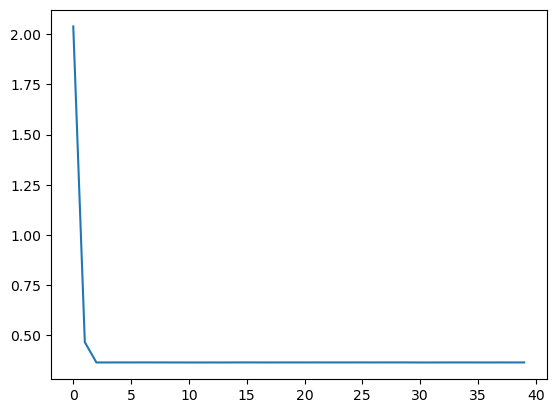

In [196]:
plt.plot(train_losses);

In [197]:
X_val_encoded = torch.tensor(encoded_test, dtype=torch.float32)

In [198]:
embeddings_train = np.array(embeddings_train)
embeddings_test = np.array(embeddings_test)
# y_train_for_emb = np.array(y_train_for_emb)

In [199]:
embeddings_train.shape, embeddings_test.shape

((57389, 256), (4378, 256))

In [200]:
l1 = np.concatenate((embeddings_train, X), axis=1)
l2 = np.concatenate((embeddings_test, test), axis=1)

Параметры подбирались через `optuna`

```
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-3, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
    }
    
    model = CatBoostRegressor(**params, verbose=False)
    score = -cross_val_score(model, l1, y, cv=3, scoring='neg_mean_squared_log_error').mean()
    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best trial:')
trial = study.best_trial
print('MSLE:', -trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f'    {key}: {value}')
```

In [234]:
from catboost import CatBoostRegressor

In [202]:
best_pipe = TransformedTargetRegressor(
                        regressor = CatBoostRegressor(iterations=815,
                        learning_rate=0.0978422598491856,
                        depth=9,
                        l2_leaf_reg =  0.07491748707304052,
                        random_strength = 0.010218193328495582,
                        border_count = 94, 
                        bagging_temperature =  0.36855247115393613,                   
                        early_stopping_rounds=10,
                        random_seed=42,
                        verbose = 0)
                        ,
    transformer = QuantileTransformer(n_quantiles = 1000 , output_distribution = 'normal')
)

In [204]:
best_pipe.fit(l1, y)

TransformedTargetRegressor(regressor=<catboost.core.CatBoostRegressor object at 0x2a9b2a850>,
                           transformer=QuantileTransformer(output_distribution='normal'))

In [205]:
y_pred_best = best_pipe.predict(l2)

In [206]:
# from scipy.special import inv_boxcox

In [207]:
# original_predictions = inv_boxcox(y_pred_best, lambda_value)

In [208]:
original_predictions = np.expm1(y_pred_best)

In [209]:
sub_cb = pd.read_csv('sample_submission.csv')
sub_cb['prediction'] = original_predictions
sub_cb

,id,prediction
0,19999,2.000000e+06
1,20000,6.738760e+06
2,20001,5.455874e+06
3,20002,5.753743e+06
4,20003,7.066610e+06
...,...,...
4373,24372,1.398078e+07
4374,24373,5.271834e+06
4375,24374,5.850000e+06
4376,24375,6.750000e+06


In [210]:
sub_cb.to_csv('79_blin_komom.csv', index = False)

### [Тут](https://dlhomeworkdashboard-eaguyxmxdffwvvhnrif82t.streamlit.app) можно посмотреть интерактивную визуализацию предиктов) 

P.s.

есть шанс, что streamlit ляжет к моменту проверки ноутбука, но всегда можно написать в тех поддержку (мне)

# Конец! Спасибо за внимание! Ставьте лайки, пишите комментарии!